In [51]:
import numpy as np  
import matplotlib.pyplot as plt 
import os
import gc
import psutil
import pandas as pd  
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import collections
from sklearn.tree import export_graphviz
import seaborn as sns   
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import matplotlib.gridspec as gridspec
import timeit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
%matplotlib inline

In [52]:
df = pd.read_csv("./dataset/chronic_kidney_disease_full.csv", na_values=['?','\t?'])
print(df.shape)
df = df.drop(columns = ['id'])
df.head()

(400, 26)


,'age','bp','sg','al','su','rbc','pc','pcc','ba','bgr',...,'pcv','wbcc','rbcc','htn','dm','cad','appet','pe','ane','class'
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [53]:
# Fill NA values with most frequent values in the column
df = df.fillna(df.mode().iloc[0])
df.isnull().sum().sum()


0

In [54]:
new_col = []
for col in df.columns:
    col = col.replace("'",'')
    new_col.append(col)
df.columns = new_col

In [55]:
str_cols = []
num_cols = []
for col in df.drop(columns = 'class').columns:
    if df[col].dtype != np.int64 and df[col].dtype != np.float64:
        str_cols.append(col)
    else:
        num_cols.append(col)
    
print("categorical columns: {}\n".format(str_cols))
print("numerical columns: {}\n".format(num_cols))


categorical columns: ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

numerical columns: ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']



In [19]:
# num_cols = ["age","blood pressure","blood glucose random","blood urea",
#             "serum creatinine","sodium","potassium","hemoglobin","packed cell volume", 
#             "white blood cell count", "red blood cell count"]
# str_cols = [x for x in df.columns if x not in num_cols]
# print("categorical columns: {}\n".format(str_cols))
# print("numerical columns: {}\n".format(num_cols))

# df_ecd = pd.get_dummies(df, columns=str_cols+['class'])
df_ecd = pd.get_dummies(df, columns=str_cols)
print("{} columns: {}".format(len(df_ecd.columns),df_ecd.columns.tolist()))

35 columns: ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'class', 'rbc_abnormal', 'rbc_normal', 'pc_abnormal', 'pc_normal', 'pcc_notpresent', 'pcc_present', 'ba_notpresent', 'ba_present', 'htn_no', 'htn_yes', 'dm_no', 'dm_yes', 'cad_no', 'cad_yes', 'appet_good', 'appet_poor', 'pe_no', 'pe_yes', 'ane_no', 'ane_yes']


In [20]:
df_ecd = df_ecd.replace('ckd',1).replace('notckd',0)

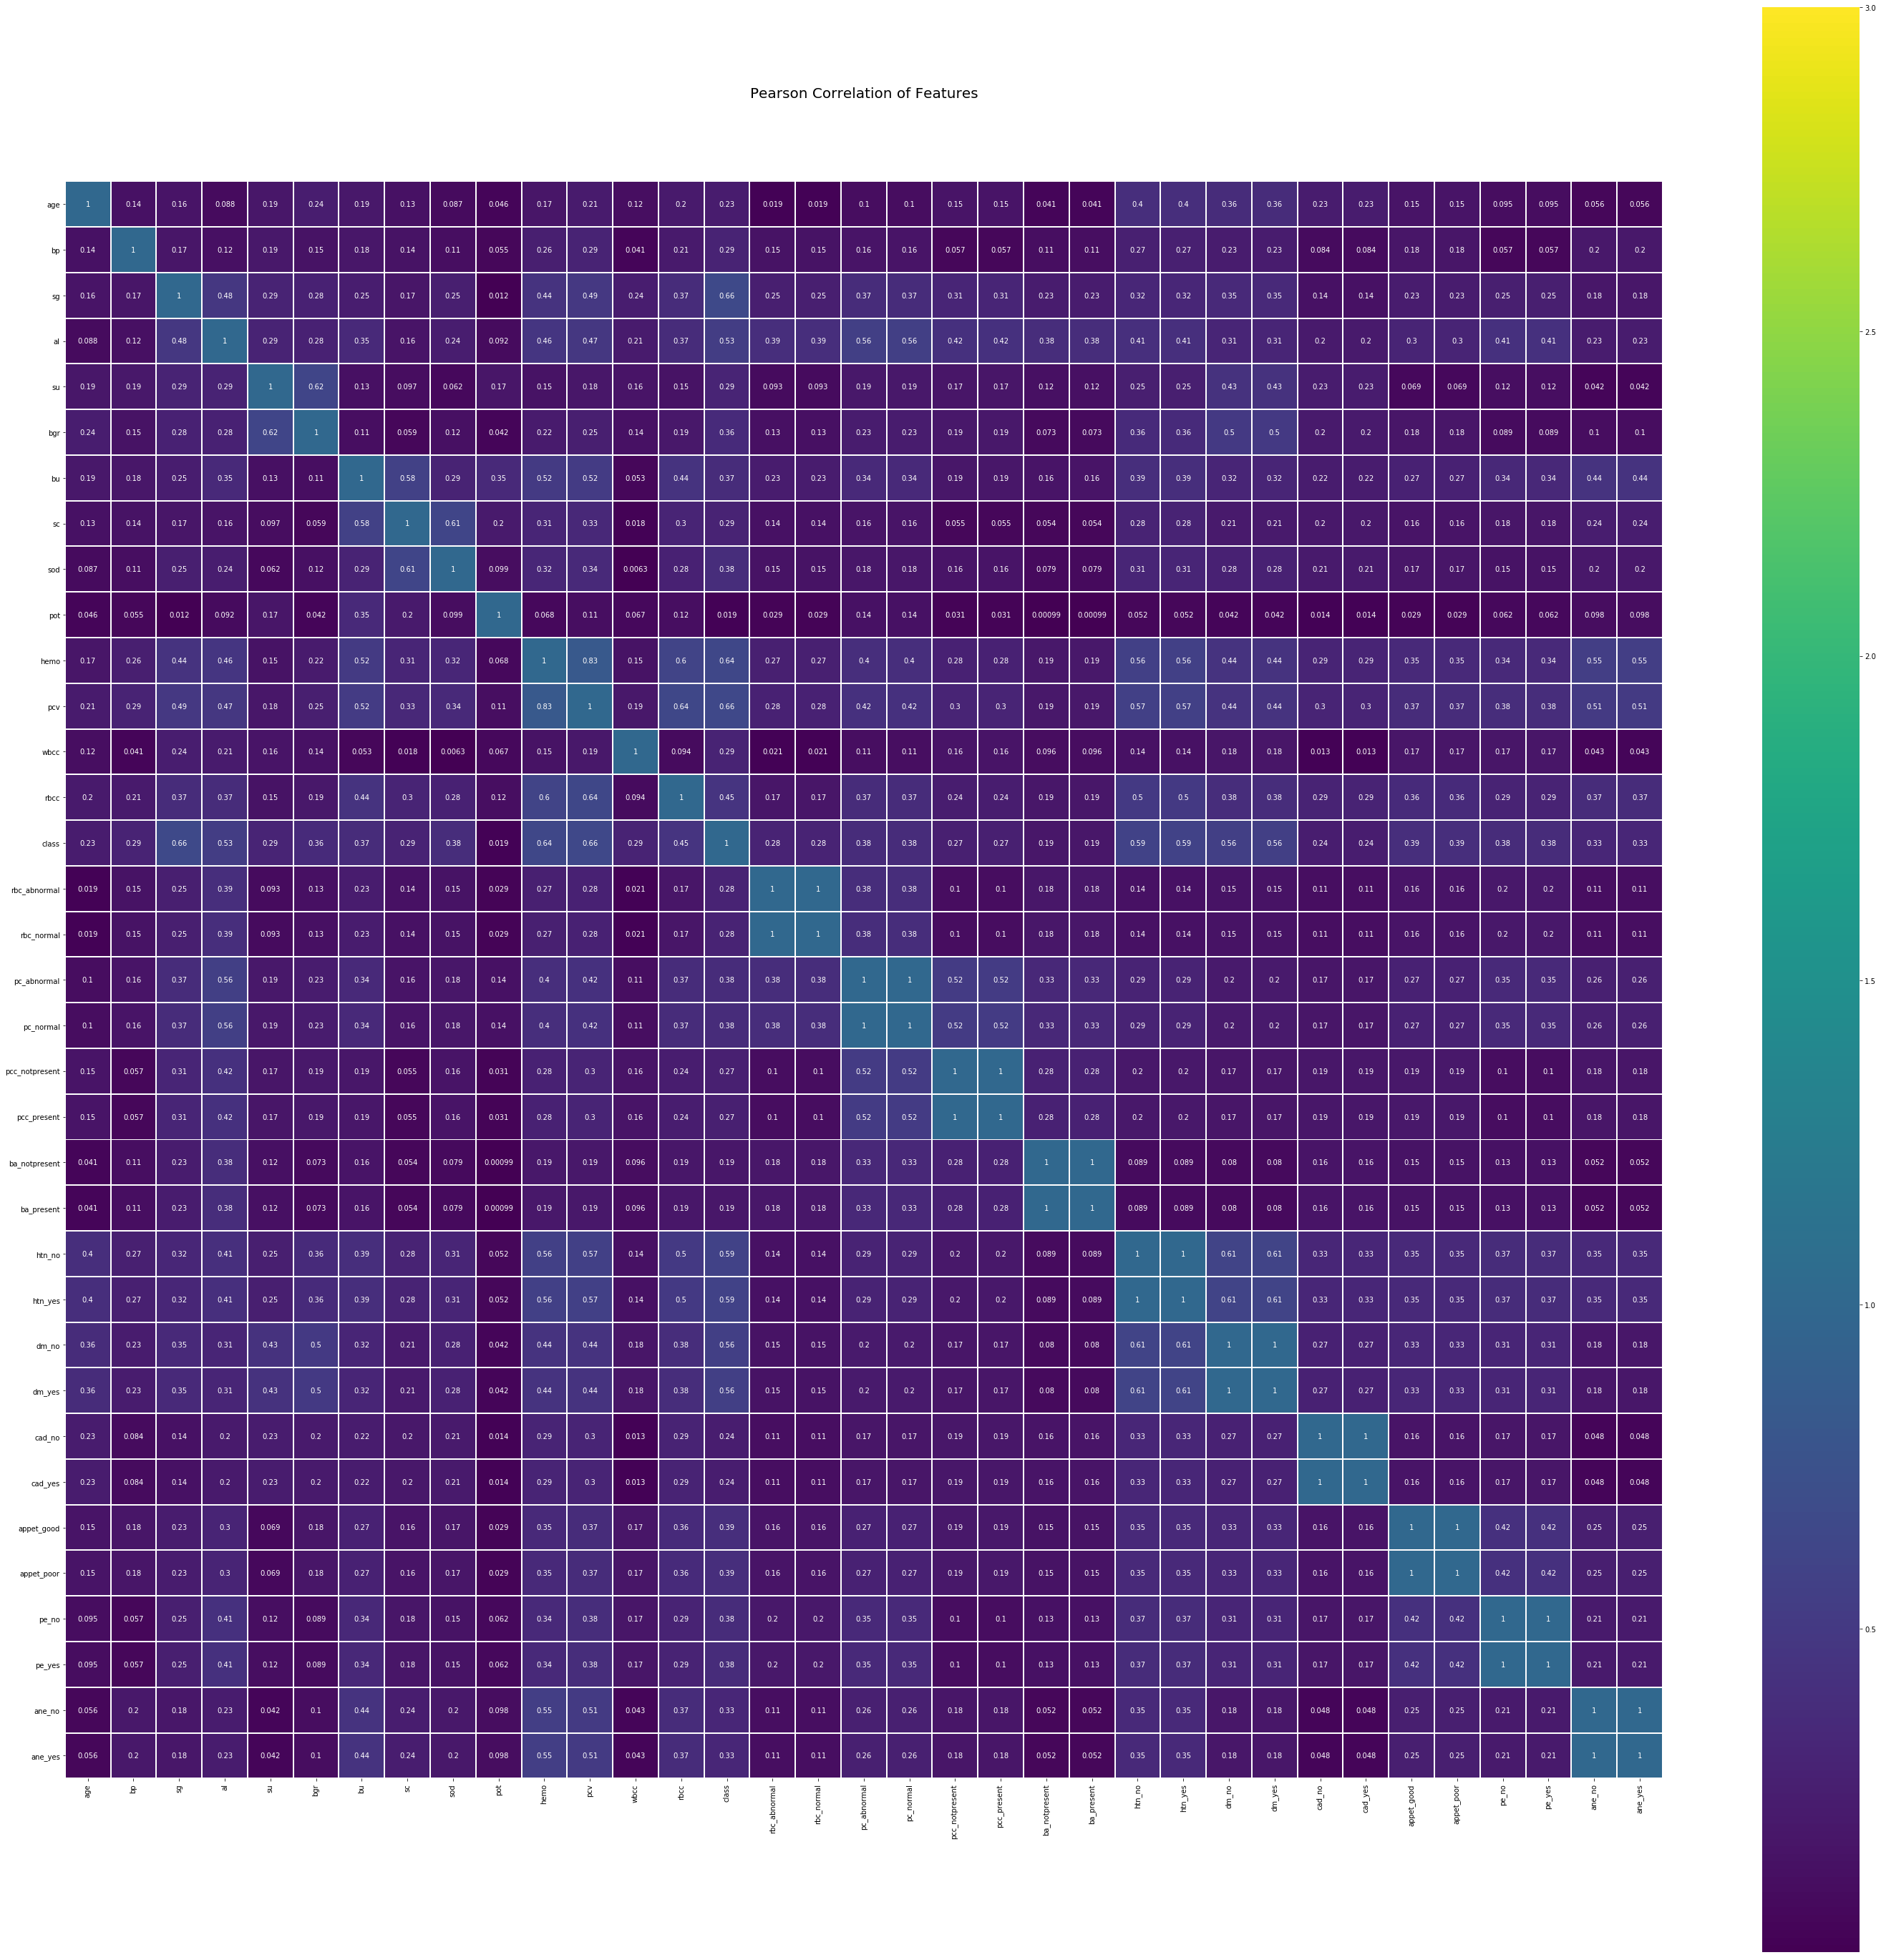

In [29]:

import seaborn as sns
colormap = plt.cm.viridis
plt.figure(figsize=(50,50))
plt.title('Pearson Correlation of Features', y=1.05, size=20)
sns.heatmap(np.absolute(df_ecd.astype(float).corr()),linewidths=1.0,vmax=3.0, square=True, cmap=colormap, linecolor='white', annot=True)


In [38]:
corr_matrix = np.absolute(df_ecd.astype(float).corr())
corr_matrix.loc['class'].sort_values(ascending=False)

class             1.000000
sg                0.659504
pcv               0.656471
hemo              0.636795
htn_no            0.590438
htn_yes           0.590438
dm_no             0.559060
dm_yes            0.559060
al                0.531562
rbcc              0.446612
appet_good        0.393341
appet_poor        0.393341
sod               0.379096
pc_normal         0.375154
pc_abnormal       0.375154
pe_no             0.375154
pe_yes            0.375154
bu                0.370233
bgr               0.358293
ane_yes           0.325396
ane_no            0.325396
su                0.294555
bp                0.293693
sc                0.291051
wbcc              0.290293
rbc_abnormal      0.282642
rbc_normal        0.282642
pcc_notpresent    0.265313
pcc_present       0.265313
cad_no            0.236088
cad_yes           0.236088
age               0.230926
ba_present        0.186871
ba_notpresent     0.186871
pot               0.018790
Name: class, dtype: float64

### Optimal Tree

# CART

In [26]:
from sklearn.metrics import precision_recall_fscore_support
from implementaion.Decisiontree import DecisionTreeNode
def find_best_clf(n, X, y, classifier, parameters, labels, cv=5):

    best_para = []
    best_tree = []
    train_score = []
    test_score = []
    train_time = []
    classification_time = []
    
    precision = []
    recall = []
    fmeasure = []
    
    for i in range(n):
        print("Iteration {}".format(i))
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        
        gridsearch = GridSearchCV(clf_dt, parameters, cv=cv, return_train_score=True)
        gridsearch.fit(X_train, y_train)
        grid_search_result = pd.DataFrame(gridsearch.cv_results_ )
        
        optimal_tree = gridsearch.best_estimator_
        
        ###########################################################
        
        best_para.append(gridsearch.best_params_)
        best_tree.append(optimal_tree)
        test_score.append(optimal_tree.score(X_test, y_test))
        train_score.append(gridsearch.cv_results_['mean_train_score'][gridsearch.best_index_])
        classification_time.append(gridsearch.cv_results_['mean_score_time'][gridsearch.best_index_])
        train_time.append(gridsearch.cv_results_['mean_fit_time'][gridsearch.best_index_])
        
        y_pred = optimal_tree.predict(X_test)
        pr, r, fs, _ = precision_recall_fscore_support(y_true=y_test, y_pred=y_pred, labels=labels)
        precision.append(pr)
        recall.append(r)
        fmeasure.append(fs)
        
    return best_para, best_tree, train_score, test_score, train_time, classification_time, precision, recall, fmeasure

In [47]:
# X = df_ecd.drop(columns='class')
# y = df_ecd['class']

# parameters = {"max_depth": [1, 5, 8, 10, 20, 100, 1000, 10000],
#               "min_samples_split": [2, 3, 5, 10, 100],
#               "min_samples_leaf": [1, 5, 10, 100, 1000, 10000],
#               "max_leaf_nodes": [None, 10, 100, 1000, 10000],
#               }

X = df.drop(columns='class')
y = df['class']
parameters = {"max_depth": [1, 5, 8, 10, 20, 100, 1000]}

labels = ["ckd","notckd"]

clf_dt = DecisionTreeNode(max_depth=1, cat_features=str_cols)
best_para, best_tree, train_score, test_score, train_time, classification_time ,precision, recall, fmeasure= find_best_clf(10, X, y, clf_dt, parameters, labels)


Iteration 0


In [15]:
for stats, name in zip([train_score, test_score, train_time, classification_time], ["train_score", "test_score", "train_time", "classification_time"]):
    print("Average {}: {}".format(name, np.average(stats)))

Average train_score: 0.9950584209937352
Average test_score: 0.9666666666666666
Average train_time: 0.8855201482772828
Average classification_time: 0.007962164878845216


In [31]:
(1-0.946969696969697)*df.shape[0]*0.33

6.999999999999994

In [25]:
for stats, name in zip([precision, recall, fmeasure], ["precision", "recall", "fmeasure"]):
    avg = np.average(stats, axis = 0)
    print("Average ckd {}: {}".format(name, avg[0]))
    print("Average notckd {}: {}".format(name, avg[1]))

Average ckd precision: 0.9760592465592703
Average notckd precision: 0.949400757052931
Average ckd recall: 0.9716545505538259
Average notckd recall: 0.9578520285952917
Average ckd fmeasure: 0.9737775269867207
Average notckd fmeasure: 0.9534171405628029


In [17]:
print(max(test_score))
idx = test_score.index(max(test_score))
print("best parameters: {}".format(best_para[idx]))

1.0
best parameters: {'max_depth': 8}


In [34]:
best_tree[idx].print_tree()

 X15 < 42.0 
  X14 < 15.2 
   X2 < 1.025 
    X17 < 5.8 
     [ckd]
     [notckd]
    X10 < 49.0 
     [notckd]
     [ckd]
   [notckd]
  X2 < 1.02 
   [ckd]
   X18 = no 
    X5 = normal 
     [notckd]
     [ckd]
    [ckd]


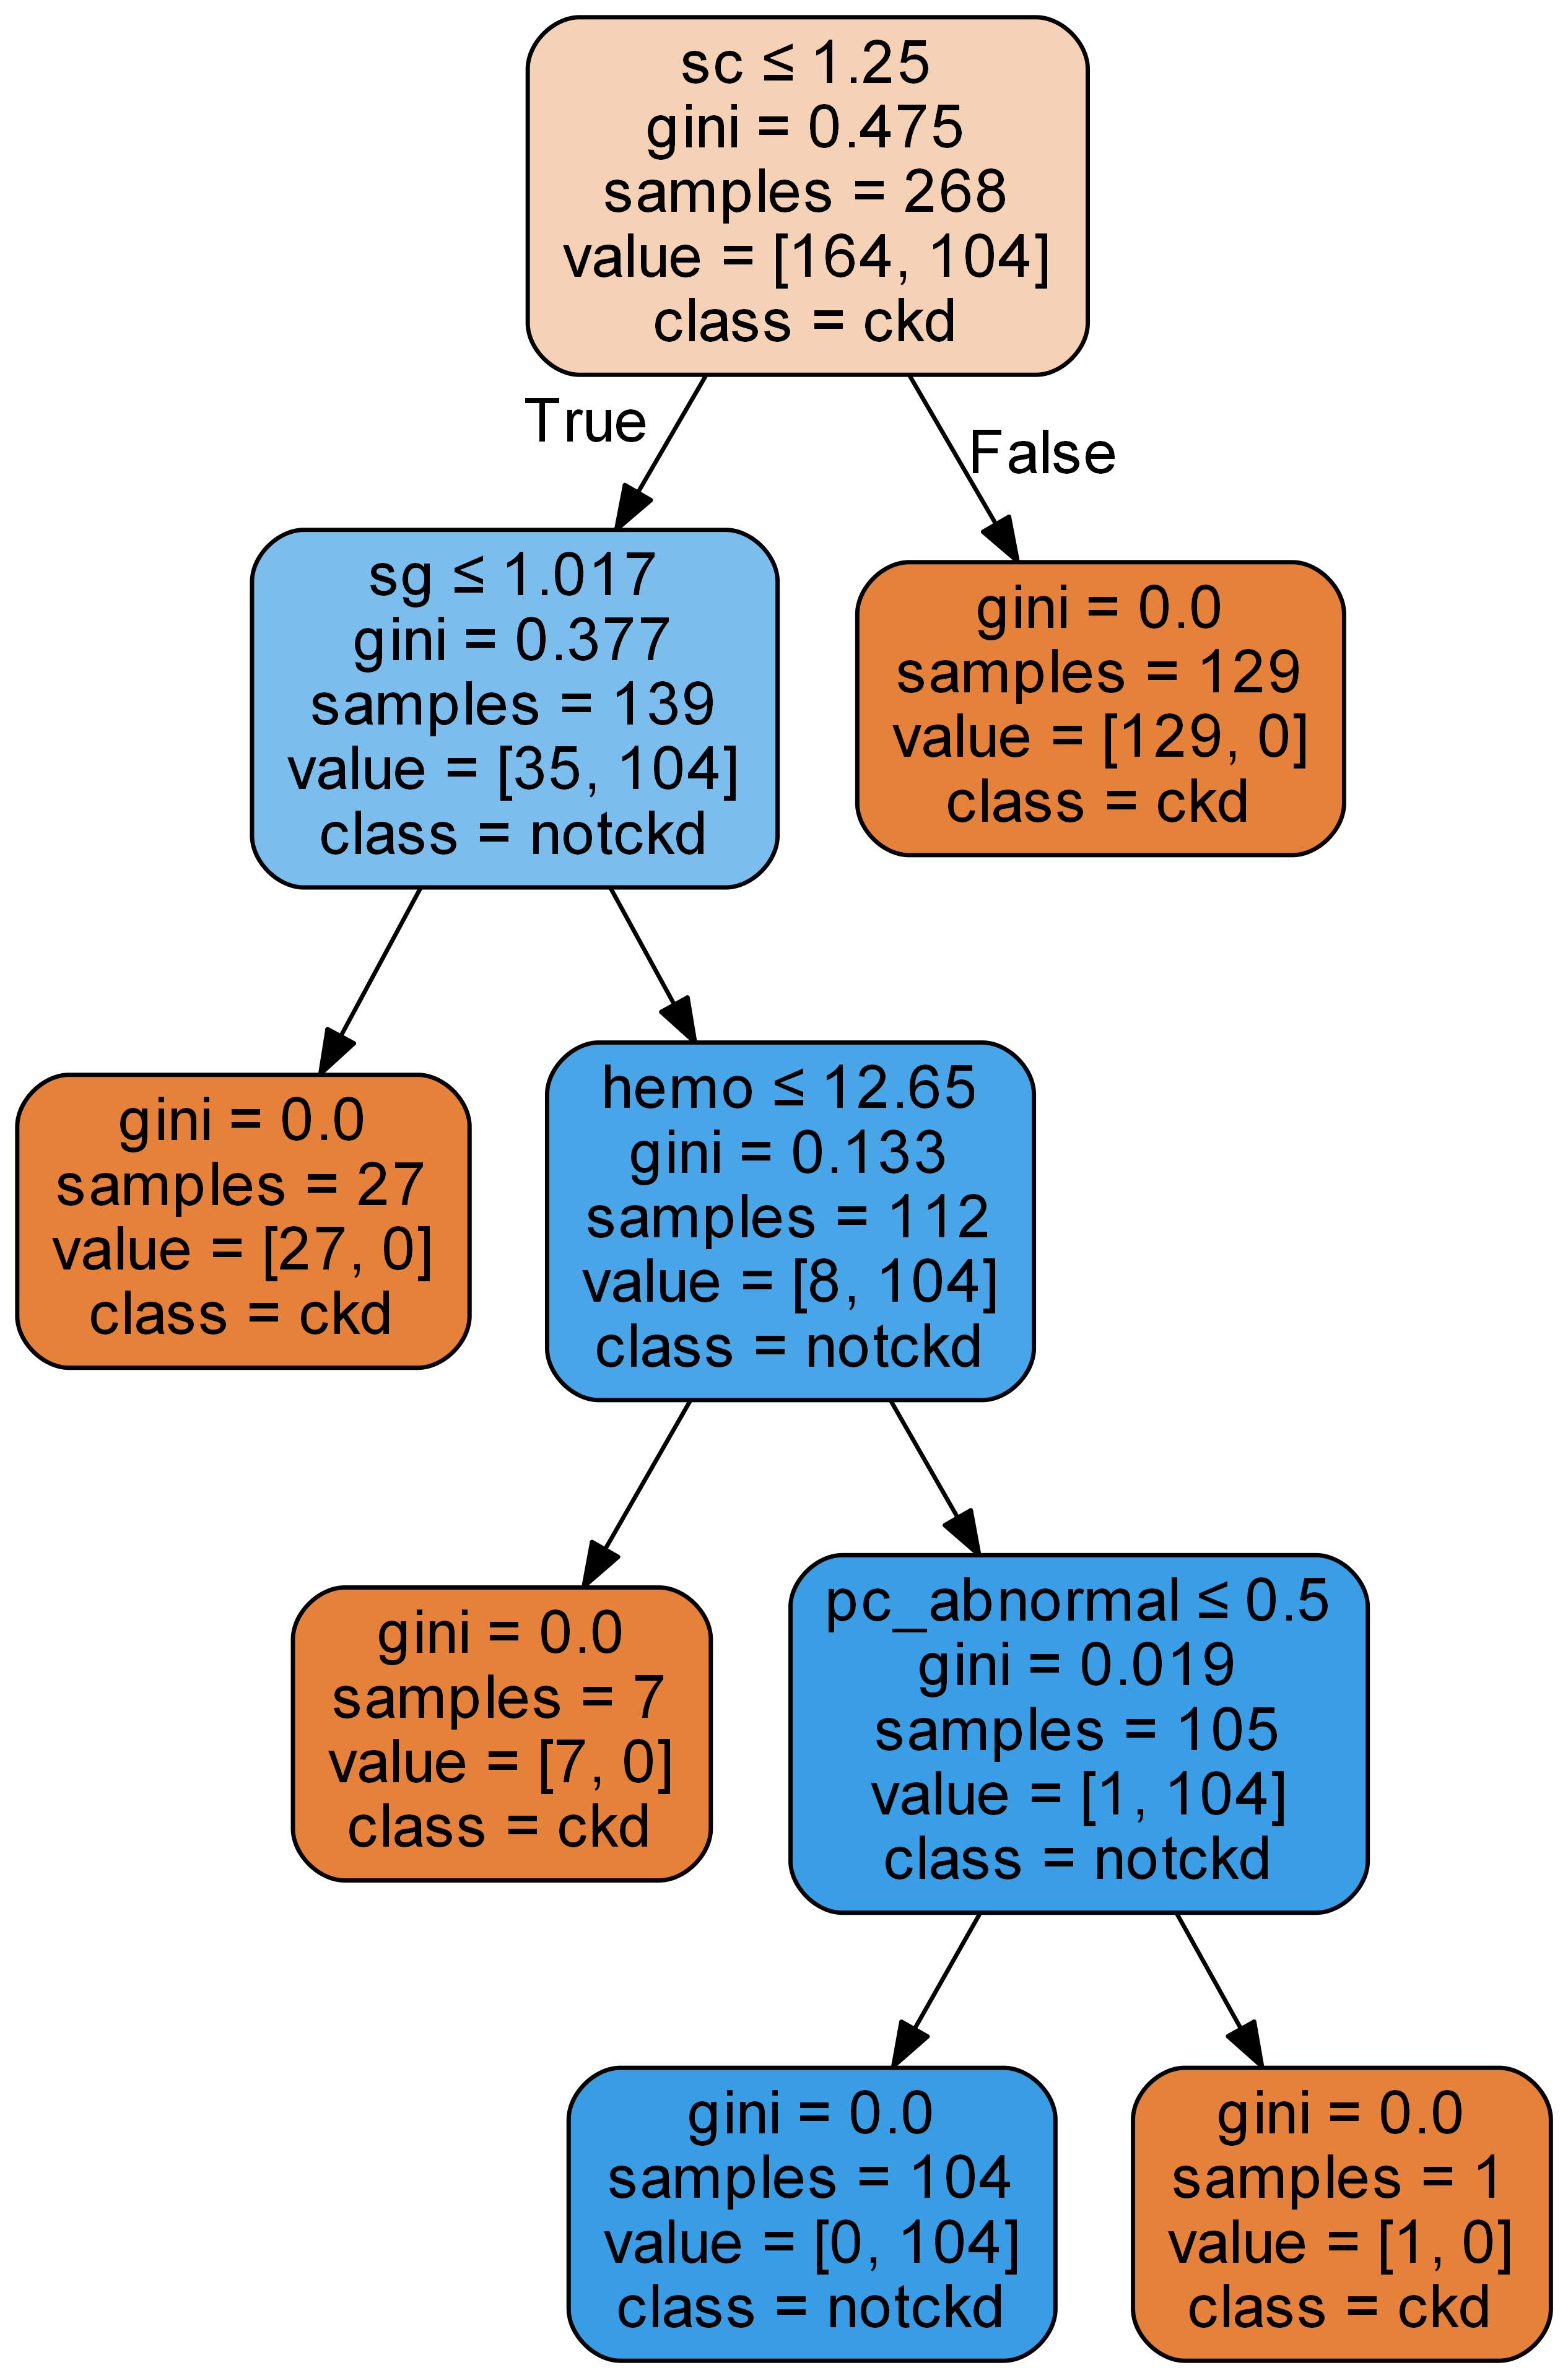

In [62]:
dot_data = StringIO()
export_graphviz(best_tree[5], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X.columns,class_names=['ckd','notckd'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.set_size('"40,40!"')
graph.write_png('Optimal_CART_chronic_kidney.png')
Image(graph.create_png())

In [57]:
corr_matrix = np.absolute(df_ecd.astype(float).corr())
corr_matrix.loc['class'].sort_values(ascending=False)


class             1.000000
sg                0.659504
pcv               0.656471
hemo              0.636795
htn_no            0.590438
htn_yes           0.590438
dm_no             0.559060
dm_yes            0.559060
al                0.531562
rbcc              0.446612
appet_good        0.393341
appet_poor        0.393341
sod               0.379096
pc_normal         0.375154
pc_abnormal       0.375154
pe_no             0.375154
pe_yes            0.375154
bu                0.370233
bgr               0.358293
ane_yes           0.325396
ane_no            0.325396
su                0.294555
bp                0.293693
sc                0.291051
wbcc              0.290293
rbc_abnormal      0.282642
rbc_normal        0.282642
pcc_notpresent    0.265313
pcc_present       0.265313
cad_no            0.236088
cad_yes           0.236088
age               0.230926
ba_present        0.186871
ba_notpresent     0.186871
pot               0.018790
Name: class, dtype: float64

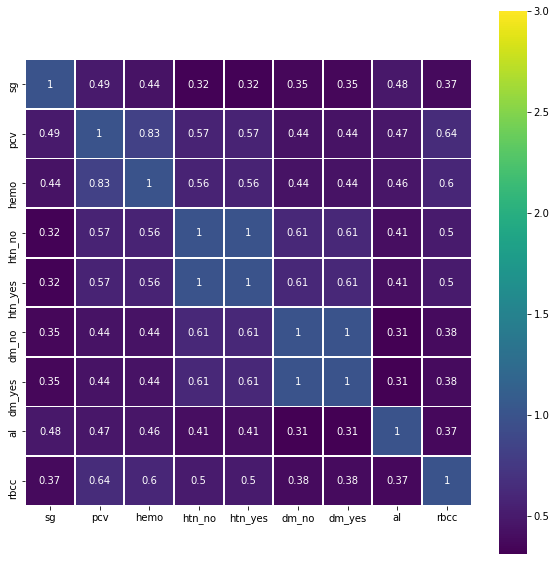

In [46]:
plt.figure(figsize=(10,10))
sns.heatmap(np.absolute(df_ecd[['sg', 'pcv', 'hemo', 'htn_no', 'htn_yes', 'dm_no', 'dm_yes','al', 'rbcc',]].astype(float).corr()),linewidths=1.0,vmax=3.0, square=True, cmap=colormap, linecolor='white', annot=True)


In [53]:
corr_matrix = np.absolute(df_ecd.astype(float).corr())
corr_matrix.loc['sc'].sort_values(ascending=False)

sc                1.000000
sod               0.611418
bu                0.581618
pcv               0.334155
hemo              0.311992
rbcc              0.298676
class             0.291051
htn_no            0.283281
htn_yes           0.283281
ane_no            0.236541
ane_yes           0.236541
dm_yes            0.209978
dm_no             0.209978
pot               0.200280
cad_no            0.196152
cad_yes           0.196152
pe_no             0.176670
pe_yes            0.176670
sg                0.171743
appet_good        0.162146
appet_poor        0.162146
al                0.161350
pc_abnormal       0.158027
pc_normal         0.158027
bp                0.143157
rbc_abnormal      0.135490
rbc_normal        0.135490
age               0.134881
su                0.096527
bgr               0.059321
pcc_notpresent    0.054675
pcc_present       0.054675
ba_notpresent     0.054129
ba_present        0.054129
wbcc              0.017922
Name: sc, dtype: float64

# Use C4.5

In [27]:
from implementaion.Decisiontree_C45 import DecisionTreeC45Node
X = df.drop(columns='class')
y = df['class']
parameters = {"max_depth": [1, 5, 8, 10, 20, 100, 1000]}

labels = ["ckd","notckd"]

clf_dt = DecisionTreeC45Node(max_depth=1, cat_features=str_cols)
best_para, best_tree, train_score, test_score, train_time, classification_time ,precision, recall, fmeasure= find_best_clf(10, X, y, clf_dt, parameters, labels)


Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


In [28]:
for stats, name in zip([train_score, test_score, train_time, classification_time], ["train_score", "test_score", "train_time", "classification_time"]):
    print("Average {}: {}".format(name, np.average(stats)))

Average train_score: 0.9984138108372032
Average test_score: 0.9848484848484848
Average train_time: 0.8928814649581909
Average classification_time: 0.007241802215576172


In [32]:
(1-0.9848484848484848)*df.shape[0]*0.33

2.000000000000013

In [29]:
for stats, name in zip([precision, recall, fmeasure], ["precision", "recall", "fmeasure"]):
    avg = np.average(stats, axis = 0)
    print("Average ckd {}: {}".format(name, avg[0]))
    print("Average notckd {}: {}".format(name, avg[1]))

Average ckd precision: 0.9945054945054945
Average notckd precision: 0.969701110155814
Average ckd recall: 0.9820328853167302
Average notckd recall: 0.9886363636363636
Average ckd fmeasure: 0.9881343046133566
Average notckd fmeasure: 0.9787742136564251


In [30]:
print(max(test_score))
idx = test_score.index(max(test_score))
print("best parameters: {}".format(best_para[idx]))

1.0
best parameters: {'max_depth': 8}


In [31]:
best_tree[idx].print_tree()

 X11 < 1.3 
  X2 < 1.02 
   [ckd]
   X3 < 1.0 
    X14 < 13.0 
     [ckd]
     X4 < 2.0 
      [notckd]
      [ckd]
    [ckd]
  [ckd]


# Using CHAID

In [75]:
"""
Author: Daiwei Lin
Date: 2019/04/01

ECE657A project

"""

import numpy as np
import pandas as pd
import math
import itertools
import copy
from scipy.stats import chi2_contingency

from sklearn.base import BaseEstimator, ClassifierMixin


class DecisionTreeCHAIDNode(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth, alpha_merge, alpha_stop, num_features=None, k=5):
        # property
        self.max_depth = max_depth

        # constant
        self.num_features = num_features
        self.alpha_merge = alpha_merge
        self.alpha_stop = alpha_stop
        self.k = k

        # variables
        self.children = list()
        self.isleaf = False

        self.split_val = None
        self.split_feature = None
        self.classification = None
        self.is_num_feature = False

        self.depth = 0

    def is_pure(self, y):
        # check whether the branch is pure() having same class )

        # compare all class label with the class of first row.
        # print(y)
        for i in y:
            if i != y[0]:
                return False
        return True

    def find_split_val(self, data, potential_features):
        # Find best split

        b_feature, b_value, b_score, b_groups = None, None, None, None

        for feature in potential_features:
            b_groups_of_cat, adj_p = self.merge(feature, data)
            #             print("feature:{} adj_p:{}, groups:{}".format(feature,adj_p, b_groups_of_cat))

            if b_score is None or adj_p < b_score:
                if b_groups_of_cat is None:
                    groups = None
                else:
                    groups = self.split(feature, b_groups_of_cat, data)

                b_index, b_value, b_score, b_groups = feature, b_groups_of_cat, adj_p, groups

        return {'index': b_index, 'value': b_value, 'groups': b_groups, 'adj_p': b_score}

    def split(self, feature, groups_of_cat, data):
        # split data according to split criteria

        # create one dic pair for each group in split value (groups_of_cat)
        groups = dict()
        groups_len = len(groups_of_cat)
        for i in range(groups_len):
            groups[i] = list()

        selected_feature = data[feature].tolist()

        for f_idx in range(len(selected_feature)):
            for g_idx in range(groups_len):
                if selected_feature[f_idx] in groups_of_cat[g_idx]:
                    groups[g_idx].append(f_idx)
                    break

        for g_idx, f_idx in groups.items():
            groups[g_idx] = data.iloc[f_idx]

        return groups

    def bonf_adjust(self, p, c, r):
        '''

        :param p: p value
        :param c: number of original categories
        :param r: number of merged categories
        :return: adjusted p value
        '''
        B = 0.0
        for i in range(r):
            B += math.pow(-1, i) * math.pow(r - i, c) / (math.factorial(r) * math.factorial(r - i))
        p * B
        #         print("p {}, c {}, r {}, B {}, adj_p {}".format(p,c,r,B, B*p))
        return p * B

    def rm_empty_col(self, c_table):
        # delete columns with all 0 in a contingency table
        # take NUMPY ARRAY as input

        # print(c_table)
        i = 0
        for col in c_table.T:
            if np.sum(col) == 0:
                # print("delete col {}".format(i))
                c_table = np.delete(c_table, i, axis=1)
                i -= 1
            i += 1
        return c_table

    def merge_single_comb(self, c_table, comb):
        # merge contingency table rows according to single combination
        cat_A = comb[0]
        cat_B = comb[1]
        c_table.loc[cat_A,] = c_table.loc[cat_A,] + c_table.loc[cat_B,]
        c_table = c_table.drop(labels=[cat_B], axis=0)
        c_table = c_table.rename(index={cat_A: str(cat_A) + ',' + str(cat_B)})

        return c_table

    def merge(self, feature, data):
        # find best merge of categories in a given feature
        # Return: b_groups: nested list of merged result
        #         adj_p: adjusted p value of merged result

        contingency_table = pd.crosstab(data[feature], data['class'])
        unique_category = contingency_table.index.tolist()
        #         print("contingency table: \n {}".format(contingency_table))
        #         print("feature:{}, unique_category:{}".format(feature,unique_category))
        b_groups, adj_p = None, None
        c = len(unique_category)

        if c == 1:
            adj_p = 1
            return b_groups, adj_p

        elif c == 2:
            sub_table = self.rm_empty_col(contingency_table.values)
            chi2, p, _, _ = chi2_contingency(sub_table)
            b_groups = list()
            for cat in unique_category:
                b_groups.append([cat])
            adj_p = p
            return b_groups, adj_p

        else:

            while True:

                # Get the best combination with
                # highest p value for all pairs of categories
                b_comb, b_pvalue = None, None
                for comb in itertools.combinations(unique_category, 2):
                    sub_table = contingency_table.loc[list(comb)]
                    sub_table = self.rm_empty_col(sub_table.values)

                    chi2, p, _, _ = chi2_contingency(sub_table)
                    if b_pvalue is None or b_pvalue < p:
                        b_comb, b_pvalue = list(comb), p

                if b_pvalue < self.alpha_merge:
                    # stop if best p is smaller than alpha_merge
                    break
                else:
                    # merge selected combination
                    # print("merge {}".format(b_comb))
                    contingency_table = self.merge_single_comb(contingency_table, b_comb)
                    unique_category = contingency_table.index.tolist()
                    # print("unique category: {}".format(unique_category))
                    # stop merging if only 2 categories left
                    if len(unique_category) <= 2:
                        break

            # Get p value for final merged contigency_table
            chi2, p, _, _ = chi2_contingency(contingency_table)
            # Bonferroni adjustment of p value
            r = len(unique_category)
            adj_p = self.bonf_adjust(p, c, r)
            b_groups = list()
            #             print(unique_category)
            for gr in unique_category:
                b_groups.append(gr.split(','))

        return b_groups, adj_p

    def grow(self, data, depth, potential_features):
        #         print("\ndepth={}, p_features={}".format(depth,potential_features))
        y = data['class'].tolist()
        if self.is_pure(y) or self.max_depth <= depth or len(potential_features) == 0:
            #             print("terminate at depth={}".format(depth))
            self.terminate(y, depth)
            return
        else:

            best_split = self.find_split_val(data, potential_features)

            if best_split['adj_p'] <= self.alpha_stop:
                self.split_val = best_split['value']
                self.split_feature = best_split['index']
                self.is_num_feature = self.split_feature in self.num_features
                # print("\nsplit on feature:{} adj_p={}".format(self.split_feature, best_split['adj_p']))

                for idx, gr in best_split['groups'].items():
                    node = DecisionTreeCHAIDNode(self.max_depth, self.alpha_merge, self.alpha_stop, num_features=self.num_features)
                    new_potential_features = copy.deepcopy(potential_features)

                    if len(self.split_val[idx]) == 1:
                        # print(self.split_val[idx])
                        # print(new_potential_features)
                        new_potential_features.remove(self.split_feature)
                    # print("---- new node with features:{}, split_val:{}".format(new_potential_features,self.split_val[idx]))
                    node.grow(gr, depth + 1, new_potential_features)
                    self.children.append(node)
            else:
                # print("adj_p {} larger than alpha stop".format(best_split['adj_p']))
                self.terminate(y, depth)
                # print("{}X{} < {} gini={}".format(self.depth*' ',self.split_feature+1, self.split_val, best_split['gini']))

        self.depth = depth
        return

    def terminate(self, y, depth):
        # define leaf node
        # most frequent class in the data as class label of this node
        # print("terminate at depth {}".format(depth))
        self.classification = max(set(y), key=y.count)
        self.isleaf = True
        self.depth = depth

    def num_to_cat(self, data, num_features, k, is_train, all_bins=None):
        # Convert numerical features into categorical
        data_discretized = copy.copy(data)
        if is_train:
            # Convert training data
            # using binning (quantile cut into k bins)
            labels = [str(x) for x in range(k)]
            numeric_bins = dict()
            print("numerical features:{}".format(num_features))
            for f in num_features:
                # print("f: {}".format(f))
                cat_col, bins = pd.qcut(data_discretized[f], k, retbins=True, duplicates='drop')
                bins = bins.astype(np.float64)
                bins[0] = -np.inf
                bins[-1] = np.inf
                numeric_bins[f] = bins
                cat_col.cat.categories = labels[:len(bins) - 1]
                data_discretized.loc[:, f] = cat_col.astype(str)
        else:
            # Convert testing data
            # match testing data X into numerical bins
            labels = [str(x) for x in range(k)]
            numeric_bins = dict()
            for f in num_features:
                bins = all_bins[f]
                cat_col = pd.cut(data_discretized[f], bins=bins, labels=labels[:len(bins) - 1])
                data_discretized.loc[:, f] = cat_col.astype(str)

        return data_discretized, numeric_bins

    def fit(self, X, y):
        # grow a tree
        # n = len(X.columns)

        if self.num_features is None:
            self.num_features = []

        potential_features = X.columns.tolist()
        X['class'] = y
        data = X
    
        data_discretized, numeric_bins = self.num_to_cat(data, self.num_features, self.k, is_train=True)

        # only define at root node
        self.numeric_bins = numeric_bins  # dictionary type
        self.default_class = y.iloc[0]
        self.grow(data_discretized, 1, potential_features)
        return self

    ##############
    # Print tree #
    ##############
    def print_tree_iterate(self, numeric_bins):
        if not self.isleaf:
            if self.is_num_feature:
                for i in range(len(self.split_val)):
                    print("{}X{} in range {} ".format(self.depth * ' ', self.split_feature, numeric_bins[self.split_feature]))
                    self.children[i].print_tree_iterate(numeric_bins)
            else:
                for i in range(len(self.split_val)):
                    print("{}X{} = {} ".format(self.depth * ' ', self.split_feature, self.split_val[i]))
                    self.children[i].print_tree_iterate(numeric_bins)
        else:
            print("{}[{}]".format(self.depth * ' ', self.classification))

    def print_tree(self):
        # this function is only defined for root node
        self.print_tree_iterate(self.numeric_bins)

    ##############
    # Prediction #
    ##############
    def predict_iterate(self, row, default_class):

        if self.isleaf:
            # is leaf node
            return self.classification
        else:
            # not leaf node
            # predict categorical feature
#             print("NodeFeature:{}, NodeSplitVal={}".format(self.split_feature,self.split_val))
            for i in range(len(self.split_val)):
                
                if row[self.split_feature] in self.split_val[i]:
                    return self.children[i].predict_iterate(row, default_class)
                
            # if it cannot find such combination of feature categories, return a default class.
            return default_class

    def predict(self, X):
        X_discretized, _ = self.num_to_cat(X, self.num_features, self.k, is_train=False, all_bins=self.numeric_bins)
#         print(X_discretized.head(2))
        prediction = []
        for _, row in X_discretized.iterrows():
            prediction.append(self.predict_iterate(row, self.default_class))

        return np.array(prediction)


In [76]:
# from implementaion.Decisiontree_CHAID import DecisionTreeCHAIDNode
X = df.drop(columns='class')
y = df['class']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 24 columns):
age      400 non-null float64
bp       400 non-null float64
sg       400 non-null float64
al       400 non-null float64
su       400 non-null float64
rbc      400 non-null object
pc       400 non-null object
pcc      400 non-null object
ba       400 non-null object
bgr      400 non-null float64
bu       400 non-null float64
sc       400 non-null float64
sod      400 non-null float64
pot      400 non-null float64
hemo     400 non-null float64
pcv      400 non-null float64
wbcc     400 non-null float64
rbcc     400 non-null float64
htn      400 non-null object
dm       400 non-null object
cad      400 non-null object
appet    400 non-null object
pe       400 non-null object
ane      400 non-null object
dtypes: float64(14), object(10)
memory usage: 75.1+ KB


In [82]:
parameters = {"max_depth": [8],
              "k":[15,20,30,50]}

labels = ["ckd","notckd"]

clf_dt = DecisionTreeCHAIDNode(max_depth=5, alpha_merge=0.05, alpha_stop=0.05, num_features=num_cols)
best_para, best_tree, train_score, test_score, train_time, classification_time ,precision, recall, fmeasure= find_best_clf(5, X, y, clf_dt, parameters, labels)


Iteration 0
numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']
Iteration 1
numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\Users\Daiwei Lin\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']
Iteration 2
numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\Users\Daiwei Lin\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']
Iteration 3
numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']
Iteration 4
numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']
numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


C:\Users\Daiwei Lin\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


numerical features:['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']


In [78]:
for stats, name in zip([train_score, test_score, train_time, classification_time], ["train_score", "test_score", "train_time", "classification_time"]):
    print("Average {}: {}".format(name, np.average(stats)))

Average train_score: 0.9899212892527389
Average test_score: 0.943939393939394
Average train_time: 4.131533794403077
Average classification_time: 0.0399678897857666


In [79]:
for stats, name in zip([precision, recall, fmeasure], ["precision", "recall", "fmeasure"]):
    avg = np.average(stats, axis = 0)
    print("Average ckd {}: {}".format(name, avg[0]))
    print("Average notckd {}: {}".format(name, avg[1]))

Average ckd precision: 0.953746694093447
Average notckd precision: 0.9314197150558335
Average ckd recall: 0.9554831225419461
Average notckd recall: 0.9300534759358289
Average ckd fmeasure: 0.9537624953223454
Average notckd fmeasure: 0.9287494437027147


In [80]:
print(max(test_score))
idx = test_score.index(max(test_score))
print("best parameters: {}".format(best_para[idx]))

0.9696969696969697
best parameters: {'k': 10, 'max_depth': 8}


In [81]:
best_tree[idx].print_tree()

 Xpcv in range [-inf 28.  32.4 36.  41.  43.  45.6 50.   inf] 
  [ckd]
 Xpcv in range [-inf 28.  32.4 36.  41.  43.  45.6 50.   inf] 
  Xrbcc in range [-inf 3.6  4.2  4.61 5.   5.2  5.8   inf] 
   Xsc in range [-inf 0.7  0.9  1.1  1.2  1.62 2.19 3.26 6.5   inf] 
    [ckd]
   Xsc in range [-inf 0.7  0.9  1.1  1.2  1.62 2.19 3.26 6.5   inf] 
    [ckd]
  Xrbcc in range [-inf 3.6  4.2  4.61 5.   5.2  5.8   inf] 
   Xdm = ['no'] 
    [notckd]
   Xdm = ['yes'] 
    [ckd]
 Xpcv in range [-inf 28.  32.4 36.  41.  43.  45.6 50.   inf] 
  Xsg in range [ -inf 1.01  1.015 1.02    inf] 
   [ckd]
  Xsg in range [ -inf 1.01  1.015 1.02    inf] 
   Xhtn = ['no'] 
    Xrbc = ['abnormal'] 
     [ckd]
    Xrbc = ['normal'] 
     [notckd]
   Xhtn = ['yes'] 
    [ckd]


In [83]:
(1-0.943939393939394)*df.shape[0]*0.33

7.399999999999998

-----------------------------------------------------------------